# Appendix

## Relationship with the course

Our project is based on two topics covered in class, logic programming (knowledge base), and heuristic search. 
We chose the Nethack HideNSeek environment because it offered us the opportunity to apply both themes in a stimulating context. The complexity of the gaming environment, with a high number of possible situations and moves, intrigued us, providing the challenge of implementing solutions that leverage both the logical knowledge base and heuristic search.

## Team Contribution

The work was divided as follows:

- Alberto and Giuseppe primarily focused on the development of the knowledge base, tackling the challenge of effectively modeling the rules of the game and interactions between elements. 
- Nicola and Chiara concentrated their efforts on Heuristic Search, aiming to optimize the search strategy to identify the most effective solutions in the complex context of Nethack hide and seek.

The entire team made significant contributions to the project, with each member bringing their added value. The synergistic collaboration among team members played a crucial role in the overall success of the project.

## *Installation and requirements
Using the requirements.txt one can build the exact environment we used for the project.

# Introduction

## The project

Our project focuses on the Minihack environment called HideNSeek. This environment consists of a labyrinth with trees and clouds. The agent's goal is to reach the stairs without being killed by the monster. There are different versions of this environment, but our project primarily concentrates on the mapped version, where the environment is fully observable, and the standard version of HideNSeek, where the environment is partially observable and revealed to the agent as it explores the map. 

Our project is structured around two distinct approaches: a knowledge base and the A* pathfinding algorithm. Initially, both techniques were explored in parallel. For both, we started with a simplified version of the problem, beginning with a fully observable environment. Initially, the map only contained trees, and later clouds and monsters were included.

Later on, we integrated the two strategies in different ways, with additional details to be shared later. Finally, we transitioned to the partially observable version of the problem. It is important to note that finding a solution in a partially observable context is complex. What will follow is just the start of a strategy, and more details will be explained later.

## Monsters

Different monsters in Nethack have different characteristics:
- Some monsters are slower than the agent, thus they occasionally skip turns;
- Many of the monsters have (powerful) ranged attacks;
- Some monsters have an ability called *infravision*, which means that they can locate the agent no matter the distance or obstacles;

Even though the agent has a leather armor, enabling him to endure hits, many of the monsters in the environment are too powerful to confront with an empty inventory.
As a consequence, we decided to focus on a subset of them, considering only two monsters: the Naga and the Giant Humanoid. The 'Hide and Seek' environment's DES file has been appropriately modified to include only these two creatures.

Both the Naga and the Giant can be lethal both up close and from a distance, but they have their respective strengths and weaknesses. The fact that these two monsters are quite different from each other, allowed us to test our approach effectively on a manageable scale. 

The Naga is a serpent-like creature known for its agility and speed. It is a very fast monster, and its long-range attack is more potent, making it a significant threat when engaged from a distance. 

The Giant is a large humanoid creature, known for its brute strength and durability. It is slower but inflicts substantial damage when in close proximity. This makes it particularly dangerous if the player gets too close. 


## Stats
The empirical evaluation is ran over 500 episodes, with a maximum number of steps of 30, using the default Minihack Reward Manager, which yields a positive score of 1 for a successful episode, and 0 otherwise. We acquired statistics over different monster pools:
- The *full* HideNSeek pool (**Giant, Naga, Titan, Dragon, Ettin, Minotaur, Lich, Ogre, Troll**);
- **Giant** only;
- **Naga** only.

We plotted the number of successful episodes (win/losses), the number of deaths caused by each monster (for the full pool), and the execution time (for A*). 

# Methodologies and Assessment

In the following we will discuss the methodologies used and the evaluations performed in each sub-task of the project.

## The Fully Observable Environment

We will start with the fully observable environment (the one that has been explored the most) in which the entirety is visible and the target is thus clear from the beginning

In [1]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from pyswip import Prolog
import IPython.display as display
from project_utils import *
from map_utils import *
from search import *
from graphics_utils import *

NUM_EP = 500


labels = {
    "N": 'Naga',
    "H": 'Giant',
    "L": 'Liches',
    "O": 'Ogre',
    "T": 'Troll',
    "D": 'Dragon',
    None: 'Unknown',    # Unkonwn in this case means that the agent got to the target (or died) without seeing any enemy
}

kb_labels = {
    "naga": 'Naga',
    "giant": 'Giant',
    "lich": 'Liches',
    "ogre": 'Ogre',
    "troll": 'Troll',
    "dragon": 'Dragon',
    'unknown': 'Unknown',   # Unkonwn in this case means that the agent got to the target (or died) without seeing any enemy
}

### Knowledge Base Approach

#### Basic Movement

The first thing we did, after setting up the environment and finding out a way to formulate and update perceptions from the game into the knowledge base, was to design and test the basic movement towards the goal. Here's a test of the agent's movement in a fully mapped environment, with just trees.

Episode 0 - 12 steps
End status: TASK_SUCCESSFUL


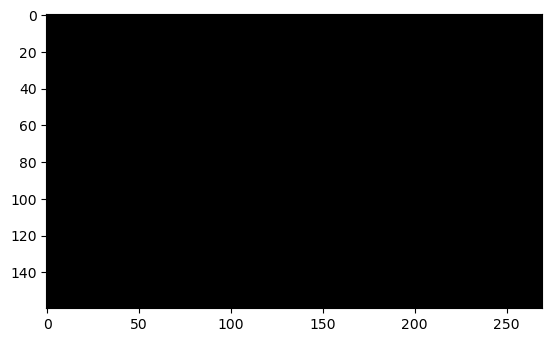

In [2]:

ENV = gym.make("MiniHack-Navigation-Custom-v0",des_file="dat/kb_movement.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))

_, _, _ = evaluate(num_ep = 1, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "slow", show = True)

#### Introducing monsters
Time to bring the monsters in.
In this version, monsters are not considered by the agent at all: he just rushes towards the stairs, ignoring them. Though counterintuitively, this has proven not to be a terrible strategy: the agent can often endure hits from the weaker monsters, or can exploit the missing turns of the slower ones, and going straight to the goal allows him to spend less time as a target for ranged attacks.

Episode 0 - 10 steps
End status: TASK_SUCCESSFUL


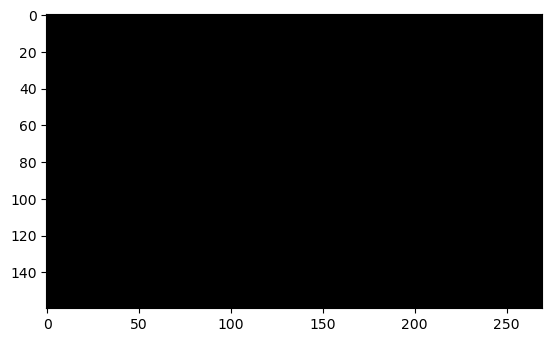

In [2]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file = 'dat/giant_fixed.des',
              observation_keys=('screen_descriptions','message','pixel','blstats'))
_, _, _ = evaluate(num_ep = 1, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "slow", show = True)

#### Loops
Since the project's bigger picture would have included a heuristic pathfinding solution, we kept the reasoning "step-by-step" in the Knowledge Base version, without using lists to build a path before moving. For this reason, in this version of the system, loops might occur: it can be the case that the optimal path is blocked by trees or walls, and the agent walks back and forth over the same two cells even if these moves lead to a dead end. In the next map we can see an example of this behaviour.

Episode 0 - 6 steps
End status: RUNNING


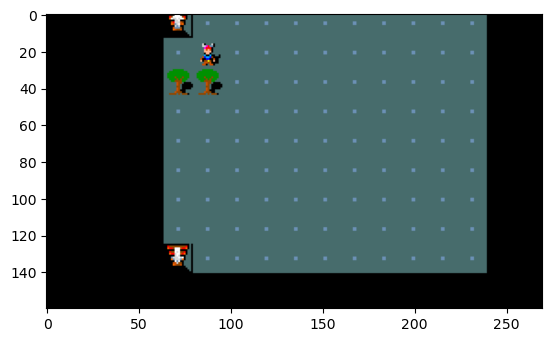

In [6]:
ENV = gym.make("MiniHack-Navigation-Custom-v0",des_file="dat/kb_loop.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
_, _, _ = evaluate(num_ep = 1, max_steps = 6, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "slow", show = True)

#### Loops fix
To avoid the occurrence of loops, we "discouraged" the agent from walking over already-walked cells. 

Episode 0 - 9 steps
End status: TASK_SUCCESSFUL


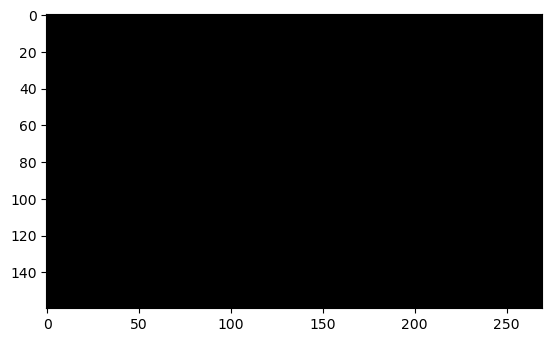

In [3]:
ENV = gym.make("MiniHack-Navigation-Custom-v0",des_file="dat/kb_loop.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
_, _, _ = evaluate(num_ep = 1, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "slow", show = True)

##### Dealing with monsters
Though not catastrophic, the strategy of ignoring the monster isn't enough, especially against the **Naga**. She rocks a powerful fire ranged attack, whilst having the same speed as the agent.
Since enemies can attack us at range from basically *any* distance, performing intricated movement strategies would both put us at risk of exceeding the maximum number of steps and give the monster more attempts to hit us at range. 
When dealing with monsters, one useful thing is that ranged attacks seem to have a *lower* chance to connect if the line of fire is not exactly *perpendicular* (or *diagonal*). Thus, we made the agent less prone to walk in those cells, as well as the cells strictly adjacent to the monster. Also, the agent keeps tracks of the last enemy position, when it disappears into clouds.


Episode 0 - 11 steps
End status: TASK_SUCCESSFUL


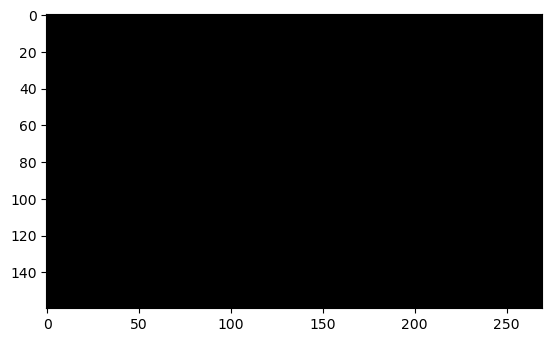

In [4]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/naga_fixed.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
_, _, _ = evaluate(num_ep = 1, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "slow", show = True)

#### Evaluation 
Now we look at some evaluation, with the different monster pools.

##### All monsters

Episode 0 - 8 steps
End status: TASK_SUCCESSFUL
Episode 1 - 2 steps
End status: DEATH
Episode 2 - 8 steps
End status: TASK_SUCCESSFUL
Episode 3 - 10 steps
End status: TASK_SUCCESSFUL
Episode 4 - 10 steps
End status: TASK_SUCCESSFUL
Episode 5 - 16 steps
End status: DEATH
Episode 6 - 6 steps
End status: DEATH
Episode 7 - 8 steps
End status: TASK_SUCCESSFUL
Episode 8 - 10 steps
End status: TASK_SUCCESSFUL
Episode 9 - 10 steps
End status: TASK_SUCCESSFUL
Episode 10 - 11 steps
End status: TASK_SUCCESSFUL
Episode 11 - 10 steps
End status: TASK_SUCCESSFUL
Episode 12 - 6 steps
End status: TASK_SUCCESSFUL
Episode 13 - 10 steps
End status: TASK_SUCCESSFUL
Episode 14 - 8 steps
End status: TASK_SUCCESSFUL
Episode 15 - 8 steps
End status: TASK_SUCCESSFUL
Episode 16 - 8 steps
End status: TASK_SUCCESSFUL
Episode 17 - 8 steps
End status: TASK_SUCCESSFUL
Episode 18 - 6 steps
End status: DEATH
Episode 19 - 10 steps
End status: TASK_SUCCESSFUL
Episode 20 - 7 steps
End status: TASK_SUCCESSFUL
Episode 21 -

<Figure size 640x480 with 0 Axes>

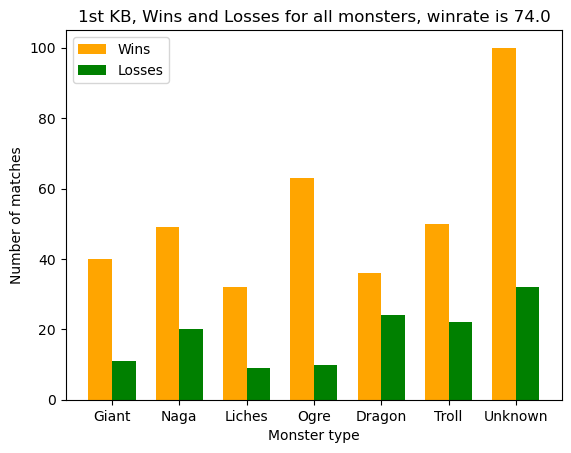

<Figure size 640x480 with 0 Axes>

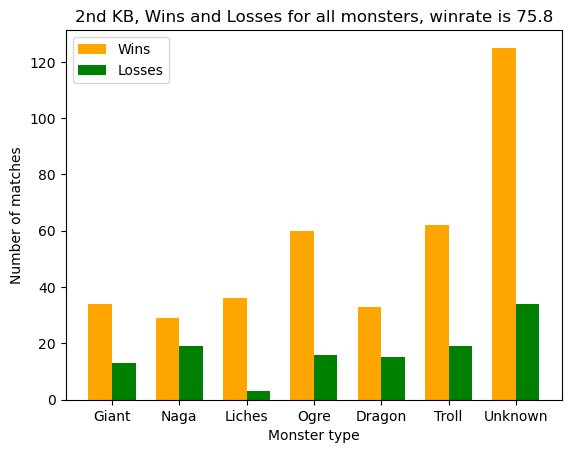

In [5]:

ENV = gym.make("MiniHack-HideNSeek-Mapped-v0",
              observation_keys=('screen_descriptions','message','pixel','blstats'))

#1st KB: ignoring monsters
monsterWins1Full, monsterLosses1Full, wins1Full = evaluate(num_ep = NUM_EP, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "fast", show = False)

winrate1Full = (wins1Full / NUM_EP) * 100

#2nd KB: avoiding monsters
monsterWins2Full, monsterLosses2Full, wins2Full= evaluate(num_ep = NUM_EP, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "fast", show = False)

winrate2Full = (wins2Full / NUM_EP) * 100

#plots
plot(monsterWins1Full, "3", 0.35, kb_labels, "Number of matches", f"1st KB, Wins and Losses for all monsters, winrate is {winrate1Full}", monsterLosses1Full, "Monster type")
plot(monsterWins2Full, "3", 0.35, kb_labels, "Number of matches", f"2nd KB, Wins and Losses for all monsters, winrate is {winrate2Full}", monsterLosses2Full, "Monster type")


##### Naga

Episode 0 - 11 steps
End status: TASK_SUCCESSFUL
Episode 1 - 10 steps
End status: TASK_SUCCESSFUL
Episode 2 - 11 steps
End status: TASK_SUCCESSFUL
Episode 3 - 11 steps
End status: TASK_SUCCESSFUL
Episode 4 - 8 steps
End status: TASK_SUCCESSFUL
Episode 5 - 10 steps
End status: TASK_SUCCESSFUL
Episode 6 - 9 steps
End status: DEATH
Episode 7 - 8 steps
End status: TASK_SUCCESSFUL
Episode 8 - 8 steps
End status: TASK_SUCCESSFUL
Episode 9 - 7 steps
End status: DEATH
Episode 10 - 7 steps
End status: TASK_SUCCESSFUL
Episode 11 - 17 steps
End status: DEATH
Episode 12 - 10 steps
End status: TASK_SUCCESSFUL
Episode 13 - 11 steps
End status: DEATH
Episode 14 - 7 steps
End status: TASK_SUCCESSFUL
Episode 15 - 8 steps
End status: TASK_SUCCESSFUL
Episode 16 - 7 steps
End status: DEATH
Episode 17 - 11 steps
End status: TASK_SUCCESSFUL
Episode 18 - 11 steps
End status: TASK_SUCCESSFUL
Episode 19 - 8 steps
End status: DEATH
Episode 20 - 8 steps
End status: TASK_SUCCESSFUL
Episode 21 - 10 steps
End statu

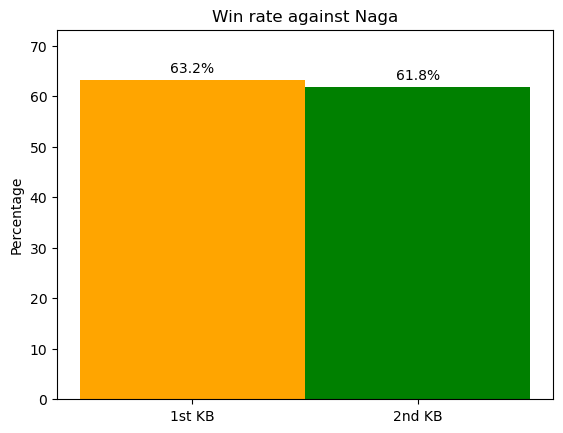

In [11]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_N.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))

#1st KB: ignoring monsters
_, _, wins1Naga = evaluate(num_ep = NUM_EP, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "fast", show = False)


#2nd KB: avoiding monsters
_, _, wins2Naga = evaluate(num_ep = 500, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "fast", show = False)


#plots
plot([wins1Naga, wins2Naga], "1", 1, ["1st KB", "2nd KB"], "Percentage", "Win rate against Naga", percentage = 500)


##### Giant

Episode 0 - 26 steps
End status: DEATH
Episode 1 - 10 steps
End status: TASK_SUCCESSFUL
Episode 2 - 11 steps
End status: TASK_SUCCESSFUL
Episode 3 - 8 steps
End status: TASK_SUCCESSFUL
Episode 4 - 30 steps
End status: RUNNING
Episode 5 - 10 steps
End status: TASK_SUCCESSFUL
Episode 6 - 7 steps
End status: DEATH
Episode 7 - 16 steps
End status: DEATH
Episode 8 - 10 steps
End status: TASK_SUCCESSFUL
Episode 9 - 8 steps
End status: TASK_SUCCESSFUL
Episode 10 - 10 steps
End status: TASK_SUCCESSFUL
Episode 11 - 10 steps
End status: TASK_SUCCESSFUL
Episode 12 - 8 steps
End status: TASK_SUCCESSFUL
Episode 13 - 12 steps
End status: TASK_SUCCESSFUL
Episode 14 - 8 steps
End status: TASK_SUCCESSFUL
Episode 15 - 11 steps
End status: TASK_SUCCESSFUL
Episode 16 - 10 steps
End status: TASK_SUCCESSFUL
Episode 17 - 10 steps
End status: TASK_SUCCESSFUL
Episode 18 - 8 steps
End status: TASK_SUCCESSFUL
Episode 19 - 8 steps
End status: TASK_SUCCESSFUL
Episode 20 - 9 steps
End status: TASK_SUCCESSFUL
Episod

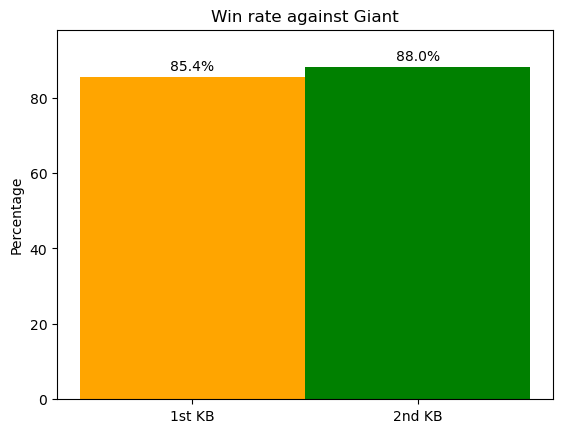

In [7]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_H.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))

#1st KB: ignoring monsters
_, _, wins1Giant = evaluate(num_ep = NUM_EP, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "fast", show = False)

#2nd KB: avoiding monsters
_, _, wins2Giant = evaluate(num_ep = 500, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "fast", show = False)

#plots
plot([wins1Giant, wins2Giant], "1", 1, ["1st KB", "2nd KB"], "Percentage", "Win rate against Giant", percentage = 500)


### Heuristic Search 

The idea was to approach the problem in an increasing level of difficulty, first working on some simpler heuristics and cost functions, up to reaching a more sofisticated level of complexity. 

We started by comparing the Euclidean Distance and the Chebyshev Distance, to better understand how to approach the problem.  After a brief analysis, we realized that the Chebyshev Distance was exactly what we needed, because it provided eight normal vectors that accurately matched the possible actions of the agent.

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=("chars", "pixel", "colors"), des_file = "dat/simple_maze.des")
solve_and_plt(env, heuristic=euclidean_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

Initially, a simpler version of the problem was tackled. An A* algorithm was implemented that could find the optimal path in a map with trees.

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/square_trees.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The algorithm also works on more intricate map configurations, that are not constrained to a square shape.

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/maze_trees.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(50, 270), plt_height=(500, 760))

The problem was made more complex with the introduction of clouds and a "grid bug," a relatively weak monster in Nethack. This creature, matching the player's speed, is unable to ever catch up with the agent, adding a strategic element to the scenario. 

To effectively face this issue, a dynamic A* algorithm was implemented. This solution recalculates the path based on whether the monster is visible or not. In scenarios where the monster is visible, the agent incurs no penalties traversing through clouded areas. Instead, in instances where the monster remains hidden, traversing through clouded regions carries a risk, as these areas might serve as secret hiding places for the lurking monster.

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/grid_bug.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The final stage of the fully observable problem involved addressing the comprehensive challenge at hand. A diverse array of monsters was integrated into the scenario. 

Initially, we relied solely on the strategy discussed up to this point, but we soon realized that it required further refinement.

In [ ]:
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The idea behind the improved strategy roots in two simple concepts:
- when the agent has the chance to see the monster in the map, it should keep itself further from it
- when the agent does not have a chance to get to know where the monster may be hiding itself, the agent must stay further from clouds as much as it might, for this very reason

In [ ]:
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="advanced", plt_width=(100, 270), plt_height=(500, 760), dynamic=True)

Let us give a brief discussion on the reasons behind the procedure rightfully working.

First, we will introduce the formulation of the Chebyshev Distance, i.e:
$$\text{let} \quad P = (p_1, p_2), \quad \text{and} \quad Q = (q_1, q_2)$$
$$d(P, Q) = \max(|p_1 - q_1|, |p_2 - q_2|)$$

The idea, as expressed before in more abstract terms, is to keep the agent as far as possible from the monster whenever it is visible. This can be obtained by setting the $g$ function of the cost function $f$ in such a way that it weights cells closer to the monster more than cells further from it. 

Let us first define the cost function $f$:
$$f(P, T) := g(P, D) + h(P, T),$$
$$\text{where P is the neighbour position},$$
$$\text{D is the danger position},$$
$$\text{and T is the target position}$$

Note: the definition of the function $g$ actually needs to be taken in a more flexible way since, as we will see later, it will be having parameters of different types throughout all the instances of the problem. Specifically, $D$ should be considered as a set, and $g$ must be defined with a specific formulation.

Anyway, what we mentioned above can be obtained by a simple manipulation of the function we used for the calculation of the distance between points in the plane, i.e. by simply calculating the reciprocal of the Chebyshev Distance between the position and the monsters itself. This gives us a function which is "rotation aware": it assigns the same value to positions falling in the radius of a circle (really squares to be precise, since the Chebyshev Distance actually is the $L_{\infty}$)).

$$\text{let} \quad \text{M be the monster's position},$$
$$\text{and} \quad \psi(P, M) := 
\begin{cases} 
    \frac{1}{d(P, M)}  & \text{if } d(P, M) > 0, \\
    maxcost & \text{if } d(P, M) = 0
\end{cases}, \quad \text{with} \quad maxcost = 10^{5}$$

$$\text{and} \quad h(P, T) := d(P, T)$$

We can obtain the cost function $f$ designed as described by setting $g = \psi$.

Notice that with $g$ we are comparing our neighbouring position $P$ with the monster position $M$, while with $h$ we are computing the exact distance (thanks to the Chebyshev Distance) between the neighbouring position $P$ and the target $T$.

For precisions's sake, we implemented the above function with a slight variation. Basically, we considered two different cases from when the agent knows where the monster is: one where $P$ is a cloud, and another one where $P$ is not a cloud. As one might think, it can be advantageous to exploit clouds in order to run off the monster, but clouds have to be weighted carefully. In fact, we did not want the agent to risk running into the monster just because it is trying to get to a cloud. To achieve this goal, we chose a simple yet effective (at least empirically) approach, based on a very simple manipulation of the above function: 

$$\psi(P, M) := 
\begin{cases} 
    \frac{1}{d(P, M)}  & \text{if } d(P, M) > 0 \quad \text{and } P \notin Clouds, \\
    \left \lfloor \frac{1}{d(P, M)} \right \rfloor  & \text{if } d(P, M) > 0 \quad \text{and } P \in Clouds, \\
    maxcost & \text{if } d(P, M) = 0
\end{cases}, \quad \text{with} \quad maxcost = 10^{5}$$

The intuition behind this, is that the floor gives a very slight advantage to the cloud position in the cost function, precisely an advantage $< 1$. This can be enough given that values will not be too large due to the size of the map, hence we will not need major adjustments.

Let us make an observation about what we have seen so far: for now, our approach only targets situations where the agent knows where the monster is located. However, in scenarios where the monster's position is unknown, we need to make some more considerations. Here, the agent should be cautious about approaching clouds, as they are ideal places for monsters to hide. To tackle this issue, we developed a specific function:

$$\varphi(P, Clouds) := \sum_{C \in Clouds} \frac{1}{d(P, C)}$$

This function $\varphi$ can be interpreted as the "danger function": it gives a value to represent how "dangerous" a position really is, basing the computation on the distance between a given position and each cloud in the map. To achieve this, we again exploited the reciprocal of the Chebyshev Distance, but this time we summed the amount of "danger" that each cloud have projected to the specific cell.

As before, we can use the original formulation, $f(P, T) := g(P, D) + h(P, T)$, to express the cost function, but this time $g = \varphi$.

$$f(P, T) := \sum_{C \in Clouds} \frac{1}{d(P, C)} + h(P, Q)$$

So, we exploited the original formulation of $f$ to handle both scenarios: one where the monster is visible and another where it is not. This was achieved by simply replacing $g$ with the appropriate function for each specific case.

Another important observation is that, in the case in which the agent does not know the monster's position, $g$ does not grow linearly as $h$ does (since it is of the form $\frac{1}{n}$ for the most part), hence this brings the conclusion that $h$ will have a bigger impact on most cases (i.e. each case where $h(P, T) > g(P, M)$, or to put it into words, every time the distance from the target is larger than the reciprocal of the distance from the monster, basically in most occasions). When we consider the case of $g = \varphi$, the reasoning actually changes a bit, since we are summing over the number of clouds in the map. In any case, this should not affect the algorithm in any particular way.

To conclude the discussion, all this machinery can be interpreted as a filtering function: the first filter applies to positions that share the same value of $h$ (since that is the most weighted value), and amongst them the agent chooses the one that is less dangerous to be percolated.

A more involved analysis might be interesting to be carried on, but the choice to stop to this point is both of practical meaning and time constraints.

However, let us us return to the core issue. 
As previously mentioned, some monsters in the MiniHack HideNSeek environment are too powerful to face with an empty inventory. Therefore, we have chosen to concentrate on a smaller group, specifically focusing on two monsters: the Naga and the Giant Humanoid.

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_NH.des", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="advanced", plt_width=(100, 270), plt_height=(500, 760), dynamic=True)

Let us examine the statistics concerning different the map configurations.

In these and the following charts, the label "unknown" refers to all the instances where the agent either won or lost without seeing which monster was on the map. In the first case, this probably happened because the agent appeared very close to the stairs and quickly reached them before the monster revealed itself (possibly hiding in the clouds). In the second case, the agent was likely killed by a ranged attack from a hidden monster. Another point to consider is that all the statistics are run over 500 episodes, with a maximum of 30 steps.

Initially, let us consider the map where both monsters have an equal probability of appearing.
The first histogram represents the total wins and losses: it is clear that the number of victories is significantly higher than the number of defeats, and this proves that our algorithm works in most cases.
The second histogram represents the total wins and losses for each type of monster. 

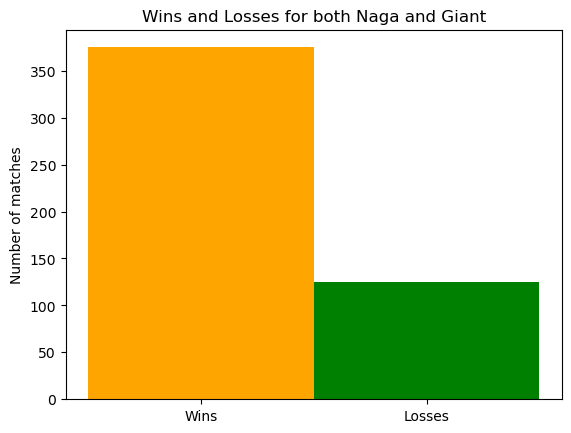

<Figure size 640x480 with 0 Axes>

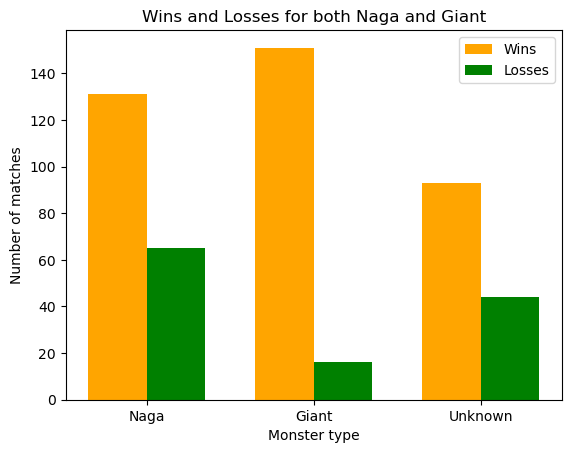

In [6]:

win, loss, _, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_NH.des", evaluation_steps=500)
winAstarFulObs=win
plot([win, loss], "1", 1, ["Wins", "Losses"], "Number of matches", "Wins and Losses for both Naga and Giant")

plot(monsters_win, "2", 0.35, labels, "Number of matches", "Wins and Losses for both Naga and Giant", monsters_loss, "Monster type")

After running the algorithm on maps containing exclusively nagas and subsequently on maps containing exclusively the giant, it is particularly interesting to analyze the success rates (win rates) in both contexts.

Generally, the win rate is higher in maps featuring only the giant compared to those with only the Naga. This is because, in maps with only the Naga, the agent tends to die more frequently without the monster being visible. This is due to the lethal long-range attack of the Naga, which hits the agent before the monster becomes visible. Additionally, the agent has no defenses against this type of attack, both because it lacks an inventory and because not seeing the monster fails to trigger the logic of the evasion mechanism in the algorithm.

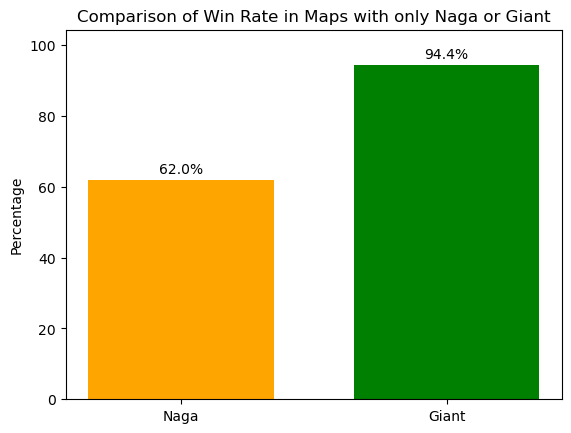

In [12]:
# NAGA
winNAGA, loss, _, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_N.des", evaluation_steps=500)

# GIANT
winGIANT, loss, _, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_H.des", evaluation_steps=500)

plot([winNAGA, winGIANT], "1", 0.70, ["Naga", "Giant"], "Percentage", "Comparison of Win Rate in Maps with only Naga or Giant", percentage=500)

Now, let us have a look at how the algorithm performs on the entire pool of monsters from HideNSeek. 

The algorithm remains effective even in this case, despite the increased difficulty that facing these monsters without an inventory can pose. In general, win and loss percentages are subject to various influencing factors, including the agent's proximity to the stairs (closer proximity increases the likelihood of reaching them without being killed) and the characteristics of the monster, coupled with its position relative to the agent (for example, favorable outcomes occur when a monster with a potent long-range attack is nearby). These variables are inherently unpredictable. 

Furthermore, in this specific context, the frequency of a monster's appearance in runs can impact the win rate, a variable beyond our control, as each monster has an equal probability of appearing on the map in every run. Therefore, to comprehensively assess the effectiveness of our algorithm for each type of monster in HideNSeek, a rigorous evaluation would involve running the algorithm on individual maps for each monster type. However, despite this, we can assert the algorithm's general effectiveness based on its performance across 500 episodes.

In [ ]:
win, loss, _, monsters_win, monsters_loss = evaluate_performance("MiniHack-HideNSeek-Mapped-v0", dynamic_path_finding, evaluation_steps=500)

plot([win, loss], "1", 1, ["Wins", "Losses"], "Number of matches", "Wins and Losses for all Monsters")

plot(monsters_win, "2", 0.35, labels, "Number of matches", "Wins and Losses for all Monsters", monsters_loss, "Monster type")


Note: as said before, "Unknown" refers to the fact that the agent has not seen any monster in between the steps it has percolated.

Another noteworthy statistic to analyze is the evaluation of the win rate and speed across the different versions of the implemented algorithm.

We consider:
- the static version (indicated with the label with "A*"), where the path is calculated only at the beginning of the episode and remains unchanged;
- the initial implementation of the dynamic version (indicated with the label "dynamic 1"), where the cost associated with clouds is based solely on the presence or absence of the monster;
- the latest dynamic version (indicated with the label "dynamic 2"), where the weight of the squares is determined through the calculation explained earlier in detail.

The comparison is performed on the map with all the monsters from Hide and Seek.

In [ ]:
#Monster pool
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])

#STATIC
start_time = time.time()
win1 = simple_evaluation(env, precision="base", dynamic=False, steps = 500)
end_time = time.time()
astar = end_time - start_time

#DYNAMIC1
start_time = time.time()
win2 = simple_evaluation(env, precision="base", dynamic=True, steps = 500)
end_time = time.time()
dynamic1 = end_time - start_time

#DYNAMIC2
start_time = time.time()
win3M = simple_evaluation(env, precision="advanced", dynamic=True, steps = 500)
end_time = time.time()
dynamic2 = end_time - start_time

plot([astar, dynamic1, dynamic2], "1", 0.70, ["Static A*", "Dynamic 1", "Dynamic 2"], "Seconds", "Comparison of Execution Time for 500 Episodes")


plot([win1, win2, win3M], "1", 0.80, ["Static A*", "Dynamic 1", "Dynamic 2"], "Number of matches", "Comparison of the Number of Games Won Against the Entire Monster Pool", percentage=500)


### Test on blend features 


The next step involved combining the two strategies, the knowledge base and the dynamic pathfinding algorithm, to analyze the obtained results and assess whether this could be a viable strategy.

In the following tests, the maximum number of steps for each episode is set to 100. Once that step limit is reached, the episode will conclude with the **noAction** state.


Let us analyze the results obtained individually with the knowledge base and heuristic search, as well as those achieved by combining the two strategies. 

The comparison is carried out on two different types of maps: only with Nagas and only with Giants.

In [ ]:
def solve_and_plt(env: gym.Env, heuristic: callable, precision: str, plt_width: Tuple[int, int], plt_height: Tuple[int, int], dynamic: bool = False, suppress = False):
    state = env.reset()
    game_map = state["chars"]
    color_map = state["colors"]
    pixel_map = state["pixel"]

    start = get_player_location(game_map)
    target = get_target_location(game_map)

    if dynamic:
        dpt_test(game_map, color_map, start, target, env, heuristic, precision=precision, graphics=True, pixel_map=pixel_map, suppress=suppress)
    else:
        path = a_star(game_map, color_map, start, target, heuristic, precision=precision)
        actions = actions_from_path(start, path[1:])
        render_actions(actions, env, pixel_map, plt_width, plt_height)

#### Test on Naga Blend

In both the case of the Naga and the Giant, we employed the following technique: initially, the agent relies solely on dynamic pathfinding algorithms. As soon as the agent spots the monster, the Knowledge Base comes into play.

This strategy was chosen because, as observed in the graph, the Knowledge Base exhibits a higher win rate than the heuristic search in maps containing only Naga.



In [ ]:
#NAGA
winNAGA2, loss,noAction, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dpt_test, des_file="dat/fully_observable_N.des", evaluation_steps=500, graphics=False)

data = [win, loss]
x_label = ["Wins", "Losses"]
if noAction:
    data.append(noAction)
    x_label.append("No Action")

plot([wins2Naga, winNAGA, winNAGA2], "1", 0.7, ["KB", "Dynamic", "Blend"], "Percentages", "Comparison Between the 3 Strategies in Maps with only Naga", percentage = 500)


#### Test on Giant blend


Initially, the same technique used for the Naga was also applied to address the Giant. 

In [ ]:
win, loss, noAction, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dpt_test, des_file="dat/fully_observable_H.des", evaluation_steps=500, graphics=False)

data = [win, loss]
x_label = ["Wins", "Losses"]
if noAction:
    data.append(noAction)
    x_label.append("No Action")

plot([wins2Giant, winGIANT, win], "1", 0.7, ["KB", "Dynamic", "Blend"], "Percentages", "Comparison Between the 3 Strategies in Maps with only Giant", percentage = 500)

This approach already seemed quite efficient, but leveraging the fact that the heuristic search has a higher win rate than the knowledge base in maps containing only Naga, we also experimented with a different strategy.

 In this case, the agent initially relies on dynamic pathfinding. When it detects the presence of the monster, it switches to the Knowledge Base. However, when the agent moves a sufficient distance away from the monster, it reverts back to employing the dynamic pathfinding algorithm.


In [ ]:
winGIANT2, loss, noAction, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dpt_testv2, des_file="dat/fully_observable_H.des", evaluation_steps=500, graphics=False)

data = [win, loss]
x_label = ["Wins", "Losses"]

if noAction:
    data.append(noAction)
    x_label.append("No Action")

plot([wins2Giant, winGIANT, winGIANT2], "1", 0.7, ["KB", "Dynamic", "Blend"], "Percentages", "Comparison Between the 3 Strategies in Maps with only Giant", percentage = 500)

As a final consideration, we interpret these results in the following sense:
- Giant's results are higher than Naga's: this happens since the former is slower than the player and has 50% chance of range attack, while the latter makes higher damage when distant from the player. This is a big advantage that motivates the fact that the winrate is higher in case of Giant's episodes,
- Dynamic A* approach outperforms the blending approach: the cause of it may be the A*'s 'straightforwardedness' (meaning its linearity in movement), since it sets the target from the beginnning and moves the path only in certain occasions; while the KB faces the map step by step, making the approach less of a linear one (still in terms of player movements),
- The former blending approach has better performance than the latter one: the rationale behind this might stand in a very simple reasoning, that is the first blending approach exploits the KB strategy to surpass the monster (eventually getting close to it). This gets the player in a very hard position to start from when using A* (which happens to be quite weak when close to the monster) causing the methodology to achieve lower results when compared to the first blending approach.

## The partially observable environment

In the partially observable environment, an agent's behavior must be adapted to handle the uncertainty and dynamics of the map. The main challenge in this scenario is the changing map configuration in each episode, making it impossible for the agent to rely on pre-existing knowledge or a predetermined path. Additionally, exploration becomes crucial since the stairs, which are the final objective, are not immediately visible.

If the stairs are visible, the agent will naturally choose them as the target. Otherwise, the idea is to choose a random position on the frontier as a temporary target. The frontier in this context refers to the limits of the area currently visible to the agent. By moving towards this position, the agent can explore new areas of the map, thereby increasing the likelihood of finding the stairs. Additionally, the algorithm keeps track of positions previously chosen as targets to avoid selecting them again.


In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/partially_observable_NH.des")

state = env.reset()
game_map = state["chars"]
color_map = state["colors"]
pixel_map = state["pixel"]

start = get_player_location(game_map)

win, loss, _, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_pathfinding_po, des_file="dat/partially_observable_NH.des", evaluation_steps=500, po = True)

plot([win,winAstarFulObs], "1", 0.70, ["Partially Observable", "Fully Observable"], "Percentages", "A* win percentage comparison on different types of environments", percentage = 500)

The final phase of our project yielded results that, while not groundbreaking, are informative for future development. Our preliminary methodology in navigating a partially observable environment was intentionally basic, serving primarily as a foundational step. This approach involved randomly selecting a point at the frontier of the map to direct the agent, a choice based on maximum visible distance. However, the high level of stochasticity inherent in this method led to a modest success rate of about 50%.

While this outcome may seem unremarkable, it provides a valuable baseline for comparison with more sophisticated strategies. We proposed several improvements, such as weighting potential targets based on their distance from the agent and adopting a strategy that encourages the agent to maintain a consistent direction before exploring other options. These ideas, grounded in principles of strategic exploration and efficiency, could significantly enhance the agent's performance.

Unfortunately, due to time constraints, we were unable to implement these advanced strategies in the current phase. Future work could focus on integrating these concepts, potentially combining them with machine learning techniques for dynamic decision-making. This would not only improve the success rate but also contribute to the broader field of AI navigation in partially observable environments. The groundwork laid by our initial approach, despite its simplicity, is a crucial step towards more intricate and effective solutions.

# Conclusions

In conclusion, our exploration encompassed both the heuristic and knowledge base approaches, each providing distinct perspectives—mathematical and logical, respectively. This exploration led us to a blending strategy, aiming to harness the strengths of both methodologies. While the results were mixed, with some aspects showing promise and others falling short, this approach offered a comprehensive and insightful view into the proposed methodologies. Looking ahead, future work could focus on extending the partially observable environment. This would involve developing more sophisticated strategies, thoughtfully crafted to leverage the unique aspects of this environment, thereby pushing the boundaries of our current understanding and capabilities in this domain.